In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Create a `HOME` constant.

In [2]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/sastrong/repos/segment-anything/notebooks


## Load Model

In [3]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

In [4]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1qbfrd98
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1qbfrd98
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '/home/sastrong/repos/segment-anything/weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)
predictor = SamPredictor(sam)

## Upload Image(s)

Zoom in on images if needed. Some ZCAM clast surveys have black outline

In [6]:
def zoom_img(img, zoom_percent):
    zoom_percent = 100 - zoom_percent
    # Get the dimensions of the image
    height, width, _ = img.shape

    # Calculate the amount to crop for zooming
    crop_width = int(width * (zoom_percent / 100)) // 2
    crop_height = int(height * (zoom_percent / 100)) // 2

    # Calculate the coordinates of the center of the image
    center_x, center_y = width // 2, height // 2

    # Calculate the coordinates of the cropped rectangle
    start_y, end_y = max(0, center_y - crop_height), min(height, center_y + crop_height)
    start_x, end_x = max(0, center_x - crop_width), min(width, center_x + crop_width)

    # Crop the image
    img_zoomed = img[start_y:end_y, start_x:end_x]

    return img_zoomed


In [7]:
def decrease_resolution(img, percent):
    # Get the dimensions of the image
    height, width = img.shape[:2]

    # Calculate the new dimensions
    new_width = int(width * (1 - (percent / 100)))
    new_height = int(height * (1 - (percent / 100)))

    # Resize the image
    img_resized = cv2.resize(img, (new_width, new_height))

    return img_resized

In [14]:
import cv2
import os
import glob

# Path to the directory with images
imgs_path = '/home/sastrong/repos/M2020_clastsurveys/'

# # Get a list of all jpeg files in the directory
imgs_files = glob.glob(os.path.join(imgs_path, '*.png'))
# imgs_files = ['../../M2020_clastsurveys/ZLF_0848_0742234350_520FDR_N0410188ZCAM07114_0340LMJ02.png']

# Initialize an empty list to store the images
imgs = []

# Loop over all files
for img_file in imgs_files:
    # Read the image
    img = cv2.imread(img_file)

    # Verify if the image is loaded
    if img is None:
        print(f'Could not open or find the image: {img_file}')
    else:
        # Zoom the image by 5%
        img_zoomed = zoom_img(img, 5)
        img_z_lowres = decrease_resolution(img_zoomed, 60)

        # Append the original and zoomed images to their respective lists
        imgs.append(img_z_lowres)

print(f"Successfully loaded and zoomed {len(imgs)} images from {imgs_path}")


Successfully loaded and zoomed 1 images from /home/sastrong/repos/M2020_clastsurveys/


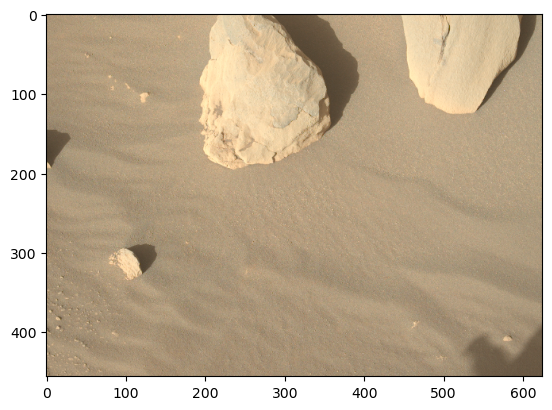

In [15]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for matplotlib
plt.show()

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [16]:
fine_mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.7,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,  # Requires open-cv to run post-processing
)

large_mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.93,
    stability_score_thresh=0.93,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=500,  # Requires open-cv to run post-processing
)

### Generate masks with SAM

In [17]:
import cv2

results_fine = []
results_large = []
max = 100
for image in imgs:
    max -= 1
    if max < 0:
        break
    sam_fine_result = fine_mask_generator.generate(image)
    sam_large_result = large_mask_generator.generate(image)
    results_fine.append(sam_fine_result)
    results_large.append(sam_large_result)
    print(f'{max} images left')

0 images left


## Filter out any massive segments (i.e. 50%+ of the photo)

In [18]:
def remove_large_bboxes(results, threshold=0.3):
    # Iterate over a copy of the list so we can remove elements while iterating.
    results_final = []
    for result in results[:]:
        annotations_final = []
        for annotation in result[:]:

            # Calculate the image size using the shape of the segmentation mask.
            # The mask should have a shape (height, width).
            image_size = annotation["segmentation"].shape[0] * annotation["segmentation"].shape[1]

            # If the area of the bounding box is more than the threshold, remove it.
            if annotation["area"] < threshold * image_size:
                annotations_final.append(annotation)
        results_final.append(annotations_final)
    return results_final

# Remove large bounding boxes from results_fine
results_fine_filtered = remove_large_bboxes(results_fine)
results_large_filtered = remove_large_bboxes(results_large)

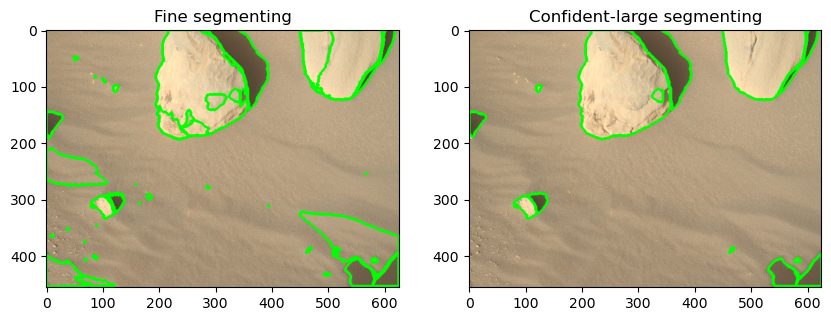

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

i = 0
original_img = imgs[i].copy()  # Copy the original image
img = imgs[i].copy()  # Copy the image that will be used to draw contours
img2 = imgs[i].copy()

for annotation in results_fine_filtered[i]:
    mask = (annotation['segmentation'].astype(bool) * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0,255,0), thickness=3)

for annotation in results_large_filtered[i]:
    mask = (annotation['segmentation'].astype(bool) * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img2, contours, -1, (0,255,0), thickness=3)    

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Convert from BGR to RGB for matplotlib
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Fine segmenting')

ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Confident-large segmenting')

plt.show()


## Combine the masks with priority to large over fine
First define helper function to check if two bboxes intersect

In [20]:
def bboxes_intersect(bbox1, bbox2):
    # Function for checking if bounding boxes intersect, as discussed above.
    x1, y1, width1, height1 = bbox1
    x1_max = x1 + width1
    y1_max = y1 + height1
    x2, y2, width2, height2 = bbox2
    x2_max = x2 + width2
    y2_max = y2 + height2
    return x1 < x2_max and x2 < x1_max and y1 < y2_max and y2 < y1_max

In [21]:
results_final = []
 
if (len(results_large_filtered) != len(results_fine_filtered)):
    print("Error: mismatch amount of images run through the models")

for i in range(len(results_fine_filtered)):
    new_result = results_large_filtered[i]
    for annotation in results_fine_filtered[i]:
        intersects = False
        for l_annotation in results_large_filtered[i]:
            if bboxes_intersect(annotation['bbox'], l_annotation['bbox']):
                intersects = True
                break
        if not intersects:
            new_result.append(annotation)
    results_final.append(new_result)

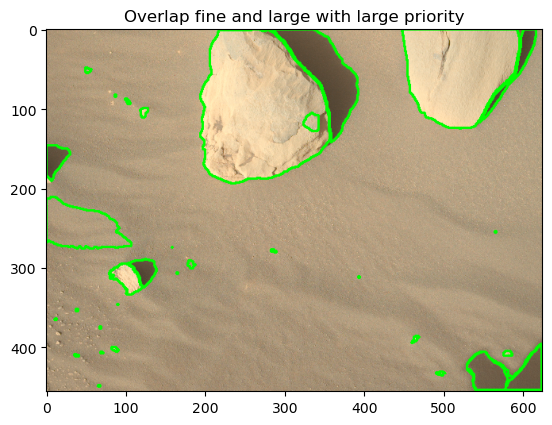

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

i = 0
original_img = imgs[i].copy()  # Copy the original image
img = imgs[i].copy()  # Copy the image that will be used to draw contours

for annotation in results_final[i]:
    mask = (annotation['segmentation'].astype(bool) * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0,255,0), thickness=2)

# Plotting
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for matplotlib
plt.title("Overlap fine and large with large priority")
plt.show()

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

In [277]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json

save_path = '/home/sastrong/repos/m_rocks_dataset_precise'
results = results_final
for i in range(len(results)):
    img = imgs[i].copy()
    img_num = "{:03}".format(i)
    entry = {"img_num": img_num, "bboxes": [], "polygons": []}
    bboxes = []
    polygons = []
    for j in range(len(results[i])):
        if (results[i][j]['area'] > 10000):
            continue

        bboxes.append(results[i][j]['bbox'])

        # Assuming the mask is a binary 2D numpy array
        mask = (results[i][j]['segmentation'] * 255).astype(np.uint8)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Simplify contours to polygons
        polygons += [cv2.approxPolyDP(contour, 1, True).tolist() for contour in contours]

    entry["bboxes"] = bboxes
    entry["polygons"] = polygons

     # save the image to save_path/images (with the new name, i.e. 023.jpg)
    img_path = os.path.join(save_path, 'images', f'{img_num}.png')
    cv2.imwrite(img_path, img)

    # save the entry as a JSON file to save_path/labels
    json_path = os.path.join(save_path, 'labels', f'{img_num}.json')
    with open(json_path, 'w') as f:
        json.dump(entry, f)